# Project1: Credit Card Approval 

#### Using Machine Learning algorithm: Logistic Regression Classifier


## Imported libraries

In [1]:
import numpy as np
import pandas as pd
import random as rn
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import KFold,cross_val_score,GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier,RandomForestClassifier,ExtraTreesClassifier

In [3]:
from keras.layers import Dense,Activation
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
import tensorflow as tf

Using TensorFlow backend.


In [4]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import category_encoders as ce

In [5]:
np.random.seed(42) #for starting Numpy generated random numbers in a well-defined initial state.
rn.seed(12345)  # for startiong core python generated random numbers in a well-defined initial state.
seed = 7
# Force TensorFlow
# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
tf.set_random_seed(1234)

#### Reading the data by replacing ?(not a number) with unknown:

In [6]:
cols_names = [ 'A'+str(i) for i in range(0,16)]
df = pd.read_csv('crx.data', 
                 header=None, names=cols_names)  # NaN are represented by '?'
df.shape

(690, 16)

In [7]:
df.columns

Index(['A0', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10',
       'A11', 'A12', 'A13', 'A14', 'A15'],
      dtype='object')

In [8]:
df.values,  df.head()

(array([['b', '30.83', 0.0, ..., '00202', 0, '+'],
        ['a', '58.67', 4.46, ..., '00043', 560, '+'],
        ['a', '24.50', 0.5, ..., '00280', 824, '+'],
        ...,
        ['a', '25.25', 13.5, ..., '00200', 1, '-'],
        ['b', '17.92', 0.205, ..., '00280', 750, '-'],
        ['b', '35.00', 3.375, ..., '00000', 0, '-']], dtype=object),
   A0     A1     A2 A3 A4 A5 A6    A7 A8 A9  A10 A11 A12    A13  A14 A15
 0  b  30.83  0.000  u  g  w  v  1.25  t  t    1   f   g  00202    0   +
 1  a  58.67  4.460  u  g  q  h  3.04  t  t    6   f   g  00043  560   +
 2  a  24.50  0.500  u  g  q  h  1.50  t  f    0   f   g  00280  824   +
 3  b  27.83  1.540  u  g  w  v  3.75  t  t    5   t   g  00100    3   +
 4  b  20.17  5.625  u  g  w  v  1.71  t  f    0   f   s  00120    0   +)

In [9]:
df.dtypes

A0      object
A1      object
A2     float64
A3      object
A4      object
A5      object
A6      object
A7     float64
A8      object
A9      object
A10      int64
A11     object
A12     object
A13     object
A14      int64
A15     object
dtype: object

In [10]:
#data distribution
s = pd.Series(df['A15'])
s.value_counts()

-    383
+    307
Name: A15, dtype: int64

#### Now, dropping/removing the row contains the string 'unknown'

In [11]:
to_drop=['?']
for col in df.columns:
    df = df[~df[col].isin(to_drop)]

df = df.replace('+',1)
df = df.replace('-',0)
df

,A0,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15
0,b,30.83,0.000,u,g,w,v,1.250,t,t,1,f,g,00202,0,1
1,a,58.67,4.460,u,g,q,h,3.040,t,t,6,f,g,00043,560,1
2,a,24.50,0.500,u,g,q,h,1.500,t,f,0,f,g,00280,824,1
3,b,27.83,1.540,u,g,w,v,3.750,t,t,5,t,g,00100,3,1
4,b,20.17,5.625,u,g,w,v,1.710,t,f,0,f,s,00120,0,1
5,b,32.08,4.000,u,g,m,v,2.500,t,f,0,t,g,00360,0,1
6,b,33.17,1.040,u,g,r,h,6.500,t,f,0,t,g,00164,31285,1
7,a,22.92,11.585,u,g,cc,v,0.040,t,f,0,f,g,00080,1349,1
8,b,54.42,0.500,y,p,k,h,3.960,t,f,0,f,g,00180,314,1
9,b,42.50,4.915,y,p,w,v,3.165,t,f,0,t,g,00052,1442,1


In [12]:
s = pd.Series(df['A15'])
s.value_counts()

0    357
1    296
Name: A15, dtype: int64

#### Seperating X(inputs) and y(ouput)

In [13]:
X = df.drop(columns='A15')
y = np.array(df['A15'])

X.shape,y.shape

((653, 15), (653,))

## Data visualization

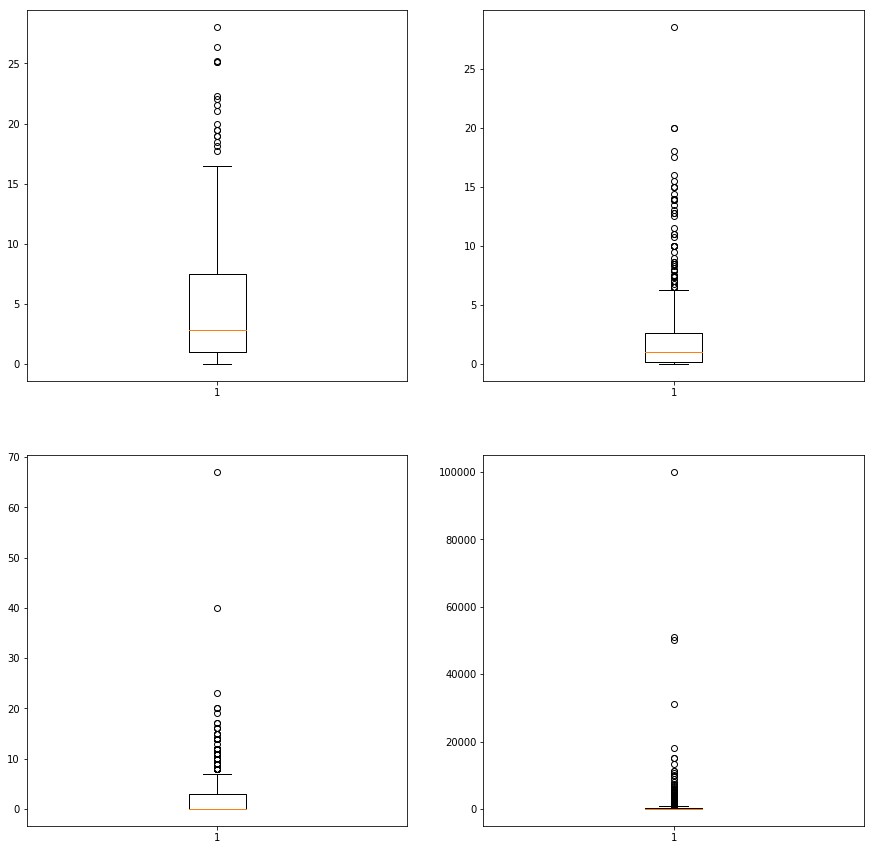

In [14]:
fig, ax = plt.subplots(2,2,figsize=(15,15))

ax[0,0].boxplot([df['A2']])

ax[0,1].boxplot([df['A7']])

ax[1,0].boxplot([df['A10']])

ax[1,1].boxplot([df['A14']])

plt.show()

#### Using Label Encoder to fit the values in a column appropriately

In [15]:
X_labelenc = X.copy()
for colname, col in X.iteritems():
    X_labelenc[colname] = LabelEncoder().fit_transform(col)

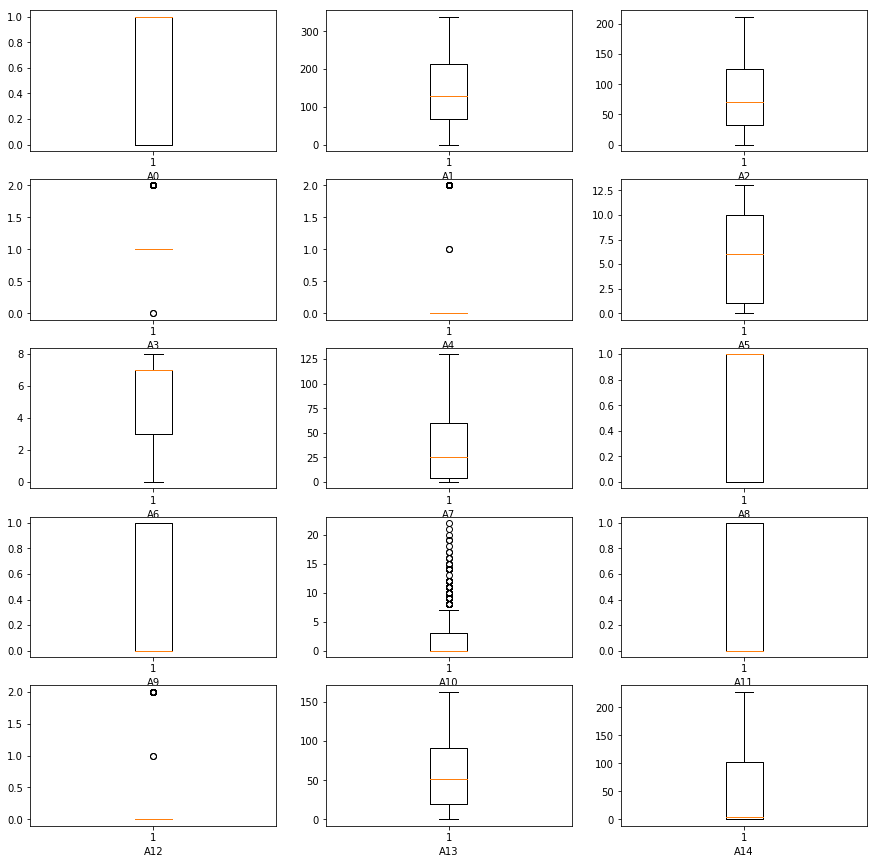

In [16]:
fig, ax = plt.subplots(5,3,figsize=(15,15))

k = 0
for i in range(0,15):
    elt = 'A'+str(i)
    p = i%3
    ax[k,p].boxplot([X_labelenc[elt]])
    ax[k,p].set(xlabel = elt)
    if (i+1)%3 == 0:
        k = k+1

plt.show()

### HISTOGRAMS

(array([357.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 296.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

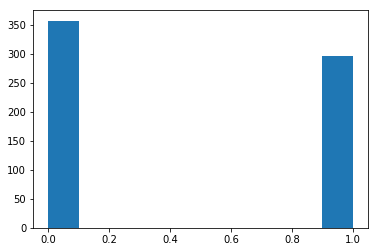

In [17]:
plt.hist(df['A15'])

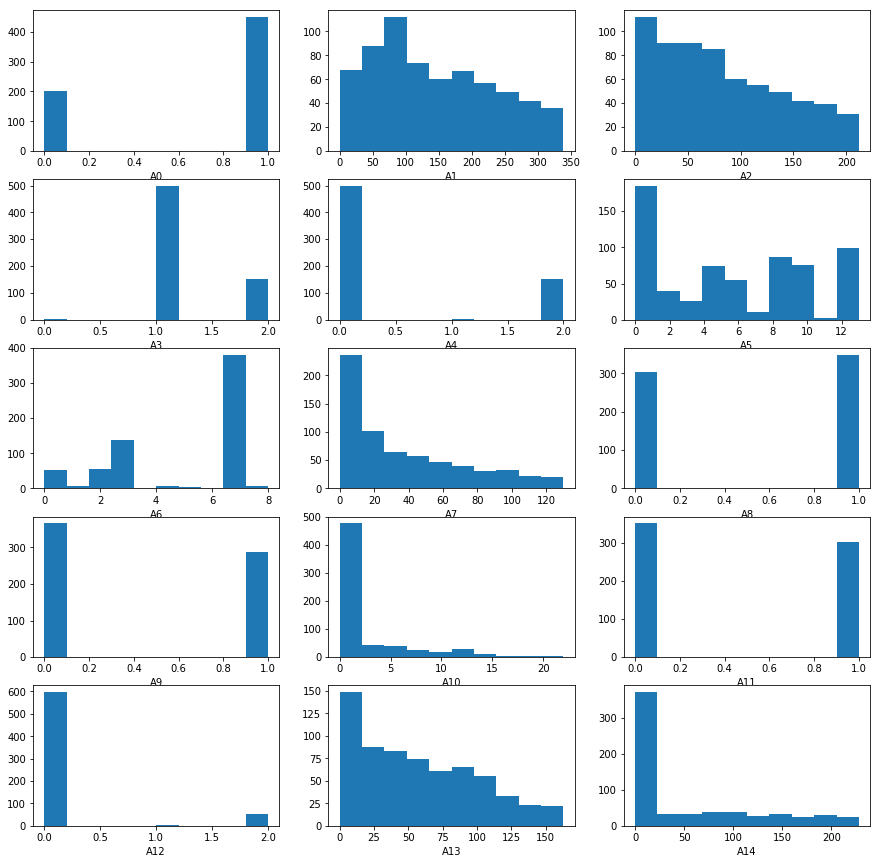

In [18]:
fig, ax = plt.subplots(5,3,figsize=(15,15))

k = 0
for i in range(0,15):
    elt = 'A'+str(i)
    p = i%3
    ax[k,p].hist([X_labelenc[elt]])
    ax[k,p].set(xlabel = elt)
    if (i+1)%3 == 0:
        k = k+1

plt.show()

### SCATTER MATRIX

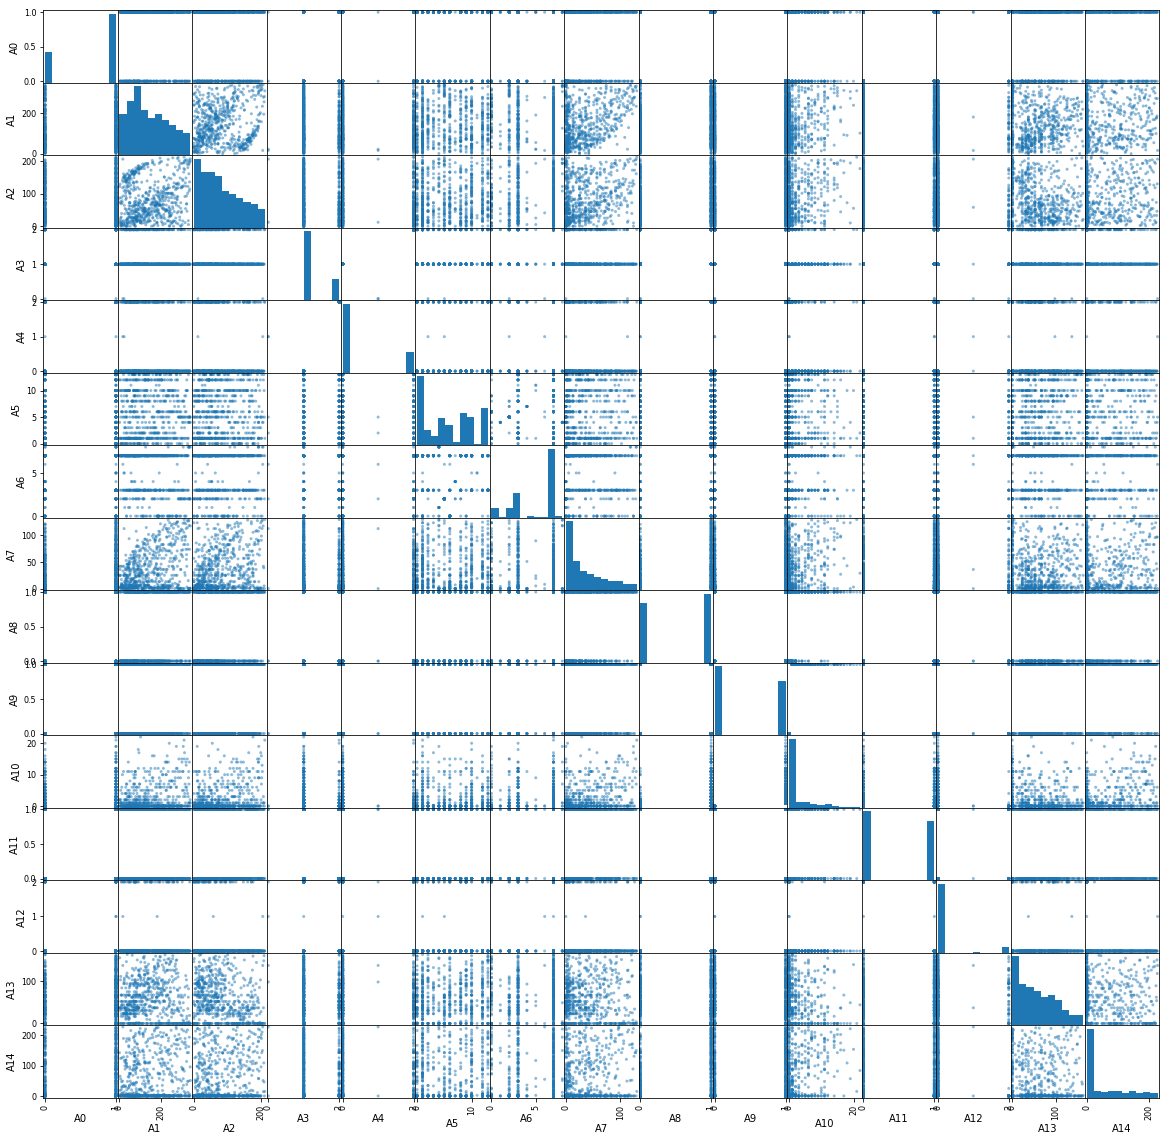

In [19]:
from pandas.plotting import scatter_matrix
scatter_matrix(X_labelenc,figsize=(20,20))
plt.show()

### CORRELATION

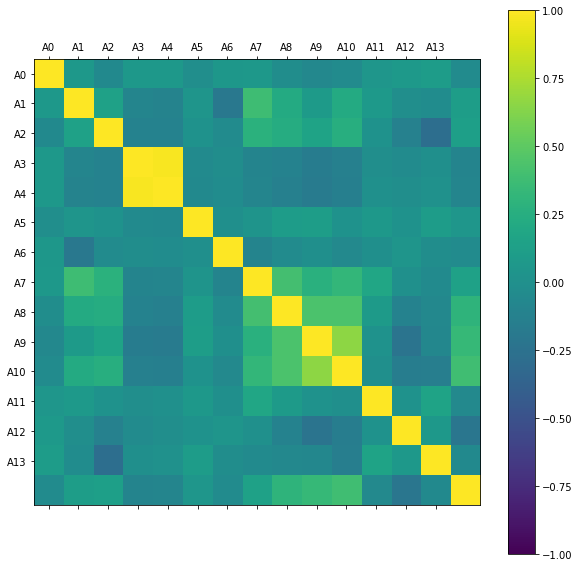

In [20]:
correlations = X_labelenc.corr()
names = ['A0', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10',
       'A11', 'A12', 'A13', 'A14']
fig, ax = plt.subplots(figsize=(10,10))
#ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,14,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.show()

In [21]:
X = X.drop(columns='A3')
X_labelenc = X_labelenc.drop(columns='A3')
X_labelenc.shape,X.shape

((653, 14), (653, 14))

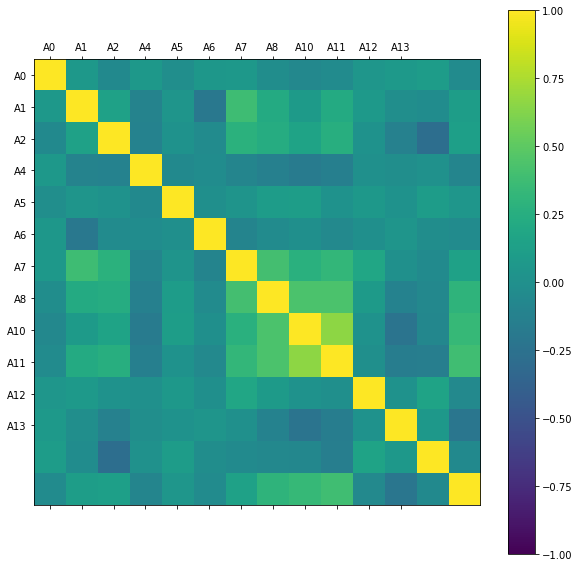

In [22]:
correlations = X_labelenc.corr()
names = ['A0', 'A1', 'A2', 'A4', 'A5', 'A6', 'A7', 'A8', 'A10',
       'A11', 'A12', 'A13', 'A14']
fig, ax = plt.subplots(figsize=(10,10))
#ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,12,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.show()

In [23]:
binenc = ce.BinaryEncoder(handle_unknown='ignore').fit(X)
# X_train_ohe = binenc.transform(X)
# X_train_ohe

output = open('binary_encoder.pkl', 'wb')
pickle.dump(binenc, output)
output.close()

In [24]:
pkl_file = open('binary_encoder.pkl', 'rb')
binenc = pickle.load(pkl_file) 
pkl_file.close()
X_binenc = binenc.transform(X)
X_binenc.head()

,A0_0,A0_1,A1_0,A1_1,A1_2,A1_3,A1_4,A1_5,A1_6,A1_7,...,A13_0,A13_1,A13_2,A13_3,A13_4,A13_5,A13_6,A13_7,A13_8,A14
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,560
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,824
3,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,3
4,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,1,0


In [25]:
X = X_binenc

#### Data splitting: train and test which is of 90% and 10% respectively.

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,shuffle=True,random_state = seed) ###cross validation
X_train.shape,X_test.shape,y_train.shape, y_test.shape


((587, 47), (66, 47), (587,), (66,))

In [27]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.05)
X_train.shape,X_valid.shape,y_train.shape, y_valid.shape

((557, 47), (30, 47), (557,), (30,))

In [28]:
model = Sequential()         ######## random seed to ignore different results....
model.add(Dense(4, input_dim=47 , activation = 'relu',kernel_initializer='random_uniform',bias_initializer='zeros'))  ##### check with changing number 
model.add(Dense(1, activation='sigmoid',kernel_initializer='random_uniform',bias_initializer='zeros'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 4)                 192       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 197
Trainable params: 197
Non-trainable params: 0
_________________________________________________________________


In [29]:
model.compile(optimizer='adadelta',loss='binary_crossentropy',metrics=['accuracy'])

In [36]:
checkpoint = ModelCheckpoint('model-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')  

model.fit(X_train,y_train,epochs= 50, batch_size=2, validation_data=(X_valid,y_valid),callbacks=[checkpoint])


Train on 557 samples, validate on 30 samples
Epoch 1/50
557/557 [==============================] - 0s 861us/step - loss: 0.2844 - acc: 0.9013 - val_loss: 0.2191 - val_acc: 0.8667

Epoch 00001: val_loss improved from inf to 0.21913, saving model to model-001-0.901257-0.866667.h5
Epoch 2/50
557/557 [==============================] - 0s 543us/step - loss: 0.2834 - acc: 0.8977 - val_loss: 0.2589 - val_acc: 0.8667

Epoch 00002: val_loss did not improve from 0.21913
Epoch 3/50
557/557 [==============================] - 0s 570us/step - loss: 0.2819 - acc: 0.9013 - val_loss: 0.2272 - val_acc: 0.8667

Epoch 00003: val_loss did not improve from 0.21913
Epoch 4/50
557/557 [==============================] - 0s 545us/step - loss: 0.2798 - acc: 0.9013 - val_loss: 0.2153 - val_acc: 0.8667

Epoch 00004: val_loss improved from 0.21913 to 0.21534, saving model to model-004-0.901257-0.866667.h5
Epoch 5/50
557/557 [==============================] - 0s 571us/step - loss: 0.2776 - acc: 0.9031 - val_loss: 0.

557/557 [==============================] - 0s 616us/step - loss: 0.2655 - acc: 0.9174 - val_loss: 0.2022 - val_acc: 0.9000

Epoch 00042: val_loss did not improve from 0.19956
Epoch 43/50
557/557 [==============================] - 0s 644us/step - loss: 0.2719 - acc: 0.9084 - val_loss: 0.5792 - val_acc: 0.8000

Epoch 00043: val_loss did not improve from 0.19956
Epoch 44/50
557/557 [==============================] - 0s 594us/step - loss: 0.2871 - acc: 0.9138 - val_loss: 0.2024 - val_acc: 0.8667

Epoch 00044: val_loss did not improve from 0.19956
Epoch 45/50
557/557 [==============================] - 0s 573us/step - loss: 0.2674 - acc: 0.9156 - val_loss: 0.2167 - val_acc: 0.9000

Epoch 00045: val_loss did not improve from 0.19956
Epoch 46/50
557/557 [==============================] - 0s 632us/step - loss: 0.2993 - acc: 0.9084 - val_loss: 0.2146 - val_acc: 0.9000

Epoch 00046: val_loss did not improve from 0.19956
Epoch 47/50
557/557 [==============================] - 0s 619us/step - loss: 

In [39]:
model = load_model('model-021-0.913824-0.900000.h5')

In [40]:
score = model.evaluate(X_test, y_test, batch_size=2)
score

66/66 [==============================] - 0s 1ms/step


[0.2871799045242369, 0.9090909090909091]

In [33]:
y_pred = model.predict_classes(X_test)
y_test,y_pred

(array([1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
        1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1]),
 array([[1],
        [1],
        [0],
        [0],
        [0],
        [0],
        [1],
        [1],
        [1],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [1],
        [0],
        [0],
        [0],
        [1],
        [1],
        [0],
        [1],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [1],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [1],
        [0],
        [

#### Confusion Matrix

In [35]:
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix) ###(tn, fp, fn, tp)

[[41  2]
 [ 3 20]]


#### Classification report

In [43]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92        43
           1       0.83      0.87      0.85        23

    accuracy                           0.89        66
   macro avg       0.88      0.89      0.88        66
weighted avg       0.90      0.89      0.89        66



#### ROC AUC curve

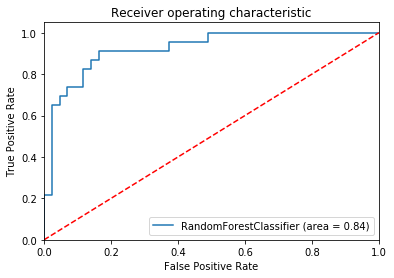

In [47]:
Randforest_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(rescaledXtest)[:,1])
plt.figure()
plt.plot(fpr, tpr, label= 'RandomForestClassifier (area = %0.2f)' % Randforest_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [48]:
gini_score = 2*auc_score() -1
gini_score

0.686552072800809